In [120]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

In [121]:
train = pd.read_csv("train.csv") 
test = pd.read_csv('test.csv')

In [122]:
print(train.shape)
print(test.shape)

(10980, 12)
(3660, 11)


In [123]:
train.head(n=5)

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [124]:
train.isnull().sum()

tweet_id                      0
airline_sentiment             0
airline                       0
airline_sentiment_gold    10949
name                          0
negativereason_gold       10956
retweet_count                 0
text                          0
tweet_coord               10204
tweet_created                 0
tweet_location             3550
user_timezone              3577
dtype: int64

In [125]:
train['airline_sentiment'].value_counts()

negative    6851
neutral     2327
positive    1802
Name: airline_sentiment, dtype: int64

In [126]:
new_train = train[['text', 'airline_sentiment']].copy()
new_test = test[['text']].copy()

In [127]:
print(new_train.shape)
print(new_test.shape)
print(new_train.head(n=5))
print(new_test.head(n=5))

(10980, 2)
(3660, 1)
                                                text airline_sentiment
0  @SouthwestAir I am scheduled for the morning, ...          negative
1  @SouthwestAir seeing your workers time in and ...          positive
2  @united Flew ORD to Miami and back and  had gr...          positive
3     @SouthwestAir @dultch97 that's horse radish 😤🐴          negative
4  @united so our flight into ORD was delayed bec...          negative
                                                text
0  @AmericanAir In car gng to DFW. Pulled over 1h...
1  @AmericanAir after all, the plane didn’t land ...
2  @SouthwestAir can't believe how many paying cu...
3  @USAirways I can legitimately say that I would...
4  @AmericanAir still no response from AA. great ...


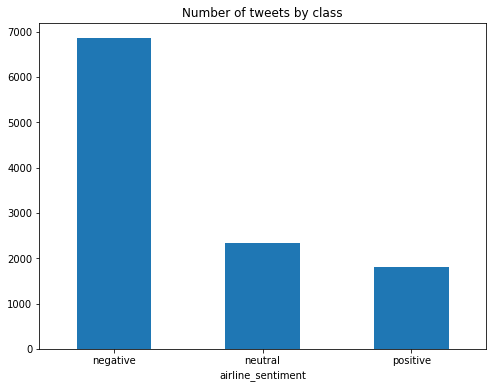

In [128]:
new_train.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [129]:
new_train.sample(5)

,text,airline_sentiment
1268,@SouthwestAir I just wanted Southwest to know ...,negative
2165,@VirginAmerica Thanks! Good times there and ba...,positive
36,@united the most frustrating flying experience...,negative
586,"@southwestair, kudos to your rep ""Patricia"" a...",neutral
4986,@USAirways glad people can put their coats in ...,neutral


In [130]:
new_train.head(n=5)
new_test.sample(5)

,text
1983,@united I somehow think I'm going to be stuck ...
1901,@JetBlue marks 15th birthday with @Airbus #A32...
1084,Okay. RT @JetBlue: Our fleet's on fleek. http:...
623,@USAirways our flight was rebooked with you an...
1516,@united Second day &amp; attempt trying to lea...


In [131]:
type(new_train['text'])
new_train['text'].shape

(10980,)

In [132]:
import nltk
from nltk.tokenize import word_tokenize

In [133]:
for i in new_train['text']:
    print(word_tokenize(i))

['@', 'SouthwestAir', 'I', 'am', 'scheduled', 'for', 'the', 'morning', ',', '2', 'days', 'after', 'the', 'fact', ',', 'yes..not', 'sure', 'why', 'my', 'evening', 'flight', 'was', 'the', 'only', 'one', 'Cancelled', 'Flightled']
['@', 'SouthwestAir', 'seeing', 'your', 'workers', 'time', 'in', 'and', 'time', 'out', 'going', 'above', 'and', 'beyond', 'is', 'why', 'I', 'love', 'flying', 'with', 'you', 'guys', '.', 'Thank', 'you', '!']
['@', 'united', 'Flew', 'ORD', 'to', 'Miami', 'and', 'back', 'and', 'had', 'great', 'crew', ',', 'service', 'on', 'both', 'legs', '.', 'THANKS']
['@', 'SouthwestAir', '@', 'dultch97', 'that', "'s", 'horse', 'radish', '😤🐴']
['@', 'united', 'so', 'our', 'flight', 'into', 'ORD', 'was', 'delayed', 'because', 'of', 'Air', 'Force', 'One', ',', 'but', 'the', 'last', 'flight', 'to', 'SBN', 'is', 'at', '8:20', ',', '5', 'mins', 'from', 'now', 'we', 'just', 'landed', '.']
['@', 'united', 'Why', 'did', 'you', 'load', 'us', 'in', 'this', 'flying', 'sardine', 'can', 'if', 

['@', 'SouthwestAir', 'Another', 'delay', '.', 'Wow']
['@', 'AmericanAir', 'trying', 'to', 'check', 'in', 'for', 'flight', '.', 'On', 'line', 'not', 'working', '&', 'amp', ';', 'agents', 'too', 'busy', 'to', 'take', 'my', 'call', '.']
['@', 'JetBlue', 'what', "'s", 'going', 'on', 'with', '1171', 'LGA-FLL..poor', 'to', 'no', 'communication', 'from', 'gate', 'agents', '?', '?']
['@', 'southwestair', '#', 'ftw', '!', '✈️', 'Hope', 'they', "'ll", 'sing', 'us', 'a', 'song', 'on', 'our', 'flight', 'to', 'Phoenix', 'today', '.', '(', '@', 'Terminal', '2', '(', 'Humphrey', ')', ')', 'https', ':', '//t.co/mAvIgetbBw']
['@', 'united', '...', 'lies', 'lies', 'lies', '...', '.still', 'sitting', 'at', 'the', 'gate', ',', 'have', 'not', 'moved', 'an', 'inch', 'http', ':', '//t.co/LulGnwEfFH']
['@', 'united', 'I', 'am', 'following', '-', 'you', 'need', 'to', 'follow', 'me', 'for', 'DM', '?']
['@', 'USAirways', '@', 'AmericanAir', 'Total', 'lack', 'of', 'cust', '.', 'service', 'for', 'a', 'mom', 'flyi

['@', 'JetBlue', 'Even', '5', 'years', 'after', 'the', 'earthquake', '...', 'Haiti', 'still', 'needs', 'helps', 'in', 'rebuilding', '#', 'flyingitforward']
['@', 'USAirways', 'despite', 'mechanical', 'issues', 'and', 'many', 'delays', 'followed', 'by', 'a', 'Cancelled', 'Flightlation', ',', 'still', 'getting', 'to', 'Vegas', 'thanks', 'to', 'great', 'gate', 'agents', '!']
['@', 'JetBlue', 'no', 'excuse', 'though', 'for', '3', 'gate', 'changes', 'though', '.']
['@', 'JetBlue', 'I', 'may', 'need', 'to', '.', 'I', 'had', 'a', '40', 'minute', 'layover', 'and', 'now', 'have', 'a', '15', 'min', 'delay', 'on', 'my', 'first', 'flight', '.']
['@', 'united', 'How', 'do', 'I', 'get', 'reimbursed', 'for', 'hotel', 'and', 'taxis', 'for', 'the', 'Cancelled', 'Flightation', '?']
['@', 'AmericanAir', 'but', 'have', 'been', 'yet', 'to', 'receive', 'assistance', 'from', 'one', 'of', 'your', 'agents', 'in', 'securing', 'a', 'new', 'connection', '.', 'Many', 'will', 'now', 'miss', 'work', 'tomorrow', '.']

['@', 'DeltaAssist', 'now', 'at', '57', 'minutes', 'waiting', 'on', 'Silver', 'Elite', 'line', 'for', 'someone', 'to', 'pick', 'up', '!', 'Help', '!']
['@', 'SouthwestAir', 'El', 'Paso', 'deals', '...', '.May❤❤❤😍🌏']
['@', 'united', 'I', 'sent', 'my', 'details', 'to', 'the', 'customer', 'care', 'link', 'you', 'sent', 'me', 'almost', 'a', 'month', 'ago', 'and', 'no', 'response', '.']
['@', 'JetBlue', 'if', 'only', 'the', 'show', 'was', 'on', 'the', 'flight', '.', 'No', 'ABC', '.', 'Oh', 'well', '.', 'I', "'ll", 'live', '.', '#', 'nexttime', '#', 'andthewinneris', '...']
['@', 'USAirways', 'thanks', 'Travis', 'at', 'PHL', 'A', 'East', 'checkin', 'for', 'knowing', 'baggage', 'policies', '.', 'Skis', '&', 'amp', ';', 'boots', 'count', 'as', '1', '.', 'Teach', 'your', 'mgr', 'who', 'did', "n't", 'know']
['@', 'SouthwestAir', 'why', 'are', 'flights', 'still', 'getting', 'out', 'of', 'Logan', 'now', '?', 'You', 'could', "n't", 'manage', 'to', 'get', 'one', 'out', 'at', '6', 'AM', ',', 'when', 

['@', 'AmericanAir', 'please', 'DM', 'me', 'a', 'way', 'to', 'get', 'in', 'touch', 'with', 'someone', 'that', 'can', 'help', '.', 'I', "'m", 'platinum', 'AA', 'and', 'considering', 'quitting', 'AA', 'BC', 'of', 'this', '.']
['@', 'AmericanAir', '-', 'Reference', 'number', 'to', 'this', 'request', ':', '1-3001408092']
['@', 'united', 'thank', 'you', 'for', 'the', 'reply', '.', 'I', 'will', 'fill', 'out', 'the', 'form', 'and', 'submit', 'it', 'as', 'requested', '.', 'Good', 'to', 'know', 'you', "'re", 'paying', 'attention', '!']
['@', 'JetBlue', 'Flight', 'I', 'want', 'to', 'book', 'was', '$', '320', 'one', 'day', ';', 'went', 'to', 'purchase', 'next', 'day', '&', 'amp', ';', 'price', 'doubled', 'to', '$', '737', '.', 'Inquiring', 'on', 'chance', 'it', 'may', 'go', 'down', '?']
['.', '@', 'united', 'you', 'should', 'really', 'have', 'that', 'addressed', 'somewhere', 'on', 'the', 'website', ',', 'find', 'that', 'completely', 'irritating', '&', 'amp', ';', 'am', 'unable', 'to', 'take', 'my

['@', 'USAirways', 'seriously', '?', 'Every', 'flight', 'I', 'have', 'had', 'the', 'past', '2', 'days', 'has', 'been', 'delayed', '.', 'Every', 'single', 'one', '.', 'Terrible']
['@', 'USAirways', 'on', 'flight', '1839', 'waiting', 'for', 'weight', 'and', 'balance', 'info', 'for', 'the', 'past', '30', 'minutes', '!', '!', '!']
['@', 'united', 'fantastic', 'night', 'of', 'waiting', '3', 'hours', 'for', 'a', 'delayed', 'airplane', ',', 'only', 'for', 'you', 'to', 'alert', 'us', 'flight', 'is', 'Cancelled', 'Flighted', 'when', 'it', 'lands', '.', '#', 'whatstatus']
['@', 'USAirways', '@', 'AmericanAir', 'no', 'one', 'appreciates', 'the', 'sass', 'of', 'the', 'gate', 'agent', 'at', 'Gate', 'C38', 'at', 'LGA', 'flight', 'US626', '.', 'Irritated', 'customers']
['@', 'AmericanAir', 'The', 'website', 'wo', "n't", 'let', 'me', 'view', 'my', 'reservation', 'due', 'to', '``', 'changes', 'made', 'outside', 'http', ':', '//t.co/nwF2FkA8fY', "''", '.', 'I', "'m", 'on', 'hold', 'now', 'to', 'get', 'h

['@', 'united', 'when', 'southwest', 'did', 'this', 'to', 'us', '--', 'a', 'mechanical', 'problem', 'at', 'least', 'they', 'gave', 'us', 'round', 'trip', 'vouchers', '.', 'Will', 'you', 'step', 'up', 'to', 'the', 'pLate', 'Flight', 'too', '?']
['@', 'AmericanAir', 'Still', 'on', 'hold', '.', 'Way', 'to', 'suck', '.']
['@', 'SouthwestAir', 'flight', 'to', 'PHL', 'from', 'FLL', 'Cancelled', 'Flighted', '2/21', 'no', 'flight', 'available', 'until', '2/24', 'done', 'with', 'SW', '.']
['@', 'AmericanAir', 'there', 'is', 'two', 'hour', 'wait']
['@', 'united', 'A', 'friend', 'traveled', 'via', 'UA1470', 'today', 'and', 'never', 'got', 'their', 'luggage', '.', 'What', 'recourse', 'does', 'the', 'person', 'have', '?', 'Buy', 'clothes', 'and', 'get', 'reimbursed', '?']
['@', 'AmericanAir', 'your', 'maint', 'delay', 'left', 'us', 'stuck', 'in', 'den', '!', '!', 'Flight', '1080', '.', 'Been', 'on', 'plane', 'for', '7', 'hrs', '.', 'Stop', 'flying', 'broke', 'french', 'planes', '!']
['@', 'USAirway

['@', 'JetBlue', 'Yes', ',', 'I', 'filed', 'yesterday', 'around', 'noon', '.', 'I', 'have', 'a', 'claim', 'number', 'but', 'they', 'have', "n't", 'contacted', 'me', 'yet', '.']
['@', 'JetBlue', 'seriously', '?', 'System', 'down', '?', 'No', 'IT', '?']
['@', 'USAirways', 'thanks', '!', 'Now', 'I', 'just', 'need', 'to', 'locate', 'where', 'my', 'luggage', 'is', '!']
['@', 'SouthwestAir', 'Thanks', 'for', 'taking', 'care', 'of', 'me', 'Today', '!', 'Michele', 'rocked', 'the', 'customer', 'service', '!', 'Gate', '25', 'HOU']
['@', 'united', 'Direct', 'Messaged', 'you', ',', 'did', "n't", 'hear', 'anything', 'back']
['@', 'united', 'Stopped', 'flying', '@', 'united', '1', 'yr', 'ago', 'bc', 'of', 'aggressive', 'policy', 'on', 'carryon', '@', 'bdl', 'listening', 'to', 'pssngrs', 'forced', 'to', 'chk', '@', 'preboard', ',', '#', 'notcomingback']
['@', 'USAirways', 'are', 'the', 'bags', 'off', 'Flight', '1898', 'CLT', 'to', 'JFK', '?', 'We', 'landed', 'last', 'night', 'just', 'before', 'midnig

['@', 'AmericanAir', 'Believe', 'me', ',', 'I', 'understand', '.', 'Flight', '#', '2955', '.', 'Was', 'originally', 'booked', 'for', 'Sunday', '.', 'Flight', 'was', 'Cancelled', 'Flighted', 'and', 'rescheduled', 'for', 'today', '.']
['@', 'VirginAmerica', 'they', 'told', 'to', 'check', 'with', 'the', 'airline', 'regulation', 'first', 'so', 'that', 'is', 'why', 'I', 'contacted', 'you', '.']
['@', 'AmericanAir', '@', 'USAirways', 'how', 'can', 'you', 'have', 'no', 'food', 'on', 'a', '4', 'hour', 'flight', '528', 'from', 'Columbus', 'to', 'Phoenix', '?', 'Starving', 'and', 'Pissed', 'off', '.', 'Ca', "n't", 'eat', 'Go', 'Go', '!']
['@', 'united', 'well', ',', 'considering', 'every', 'agent', 'before', 'claimed', 'they', 'were', 'unable', 'to', 'help', 'with', 'everything', 'else', ',', 'why', 'waste', 'more', 'time', 'to', 'hear', "'call", 'corp', "'"]
['@', 'united', 'I', 'asked', 'a', 'legitimate', 'question', 'about', 'systemwide', 'vs.', 'localized', 'problems', ',', 'and', 'got', 'ba

['@', 'SouthwestAir', 'INSANE', 'traffic', 'in', 'LA', '.', 'Trying', 'to', 'call', 'you', 'all', 'to', 're', 'schedule', 'flight', 'but', 'been', 'on', 'phone', 'for', '20', 'minutes', 'and', 'nothing', '.']
['.', '@', 'united', 'This', 'flight', 'attendant', 'was', 'extremely', 'helpful', 'to', 'a', 'woman', 'who', 'had', 'a', 'hard', 'time', 'walking', '.', 'Very', 'touching', '!']
['@', 'AmericanAir', '6', 'hours', 'to', 'get', 'backs', 'back', 'after', 'being', 'sat', 'on', 'a', 'plane', 'for', '4', 'hours', 'to', 'have', 'flight', 'Cancelled', 'Flightled', 'with', 'only', 'one', 'small', 'drink']
['@', 'united', 'just', 'wanted', 'to', 'let', 'you', 'know', 'how', 'wonderful', 'Rosetta', 'the', 'gate', 'agent', 'was', 'working', 'flight', '6457', 'Dan', 'to', 'Ase', '.', 'Let', 'her', 'know', 'she', 'wasappreciated']
['@', 'AmericanAir', '@', 'robinreda', 'being', 'stuck', 'two', 'days', 'in', 'the', 'airport', 'is', 'not', 'something', 'pretty', 'normal', '.', 'I', 'am', 'positi

['@', 'AmericanAir', 'Same', 'as', 'yesterday', "'s", 'Cancelled', 'Flighted', 'flight', '.', 'AA104', '.', 'Your', 'customer', 'support', 'is', 'just', 'awful', '!']
['@', 'AmericanAir', 'I', 'called', 'reservation', 'at', '1', 'am', 'and', 'I', "'m", 'still', 'waiting', 'for', 'someone', 'to', 'call', 'me', 'back']
['@', 'united', 'better', 'train', 'your', 'support', 'staff', 'with', 'appropriate', 'decorum', ',', 'consider', 'revisiting', 'your', 'terrible', '``', 'provide', 'a', 'death', 'certificate', "'", 'policy']
['@', 'United', 'OMG', 'WHERE', 'IS', 'MY', 'BAG', '?', '?', '?', 'YYZUA70435', '-', 'enough', 'with', 'the', 'shenanigans', 'already', '.', 'It', "'s", 'getting', 'real', 'old', 'real', 'quick', '!', '!']
['@', 'AmericanAir', 'You', "'ve", 'now', 'put', 'me', 'on', 'a', 'BA', 'flight', '-', 'can', 'I', 'get', 'access', 'for', '2', 'for', 'the', 'lounge', '?', 'Been', 'at', 'ORD', 'for', '11.5', 'hrs', 'now', 'and', 'still', 'have', '5', 'to', 'go', '.']
['@', 'Americ

['@', 'JetBlue', 'They', 'were', "n't", 'on', 'any', 'flight', ',', 'they', 'just', 'came', 'Late', 'Flight', '.', 'Your', 'JetBlue', 'employee', 'just', 'informed', 'us', '!']
['@', 'AmericanAir', 'you', 'think', 'I', 'have', "n't", 'tried', 'that', 'multiple', 'times', '?', '?', 'The', '``', 'status', "''", 'of', 'my', 'bag', 'is', 'that', 'it', 'should', "'ve", 'been', 'here', 'YESTERDAY', '.', 'So', 'disgusted', '.']
['@', 'SouthwestAir', 'flight', 'just', 'Cancelled', 'Flighted', '.', 'Can', 'you', 'help', 'me', 'rebook', '?']
['@', 'united', 'Lovely', 'new', 'plane', 'from', 'LGA', 'to', 'ORD', 'but', 'no', 'power', 'outlets', '?']
['@', 'AmericanAir', '#', 'AmericanView', 'Sweet', 'Home', 'Chicago', 'http', ':', '//t.co/J6icLV8DTs']
['@', 'JetBlue', 'Well', ',', 'I', 'try', '!', 'See', 'you', 'soon', '!', '!', '@', 'JayVig']
['@', 'SouthwestAir', 'on', 'brd', 'now.frustrated', 'we', 'go', '2', '#', 'BUF', 'not', '#', 'ROC.if', 'tld', 'flt', 'was', 'gng', '2b', 'held', 'earlier',

['@', 'JetBlue', 'I', 'have', 'the', 'emails', 'that', 'they', 'are', 'on', 'their', 'way']
['@', 'USAirways', 'Only', 'the', 'JFK', 'baggage', 'office', 'is', 'open', 'to', 'help', 're-book', 'all', 'of', 'us', 'on', 'Cancelled', 'Flightled', 'flight', '3121', 'to', 'DCA', '.', 'Shameful', '.']
['@', 'SouthwestAir', 'thx', '-', 'fingers', 'crossed', 'they', 'are', 'found', '.']
['@', 'united', 'mechanical', 'issue', '.', 'Looks', 'like', 'they', 'got', 'it', 'fixed', '!', 'Thanks', 'for', 'your', 'concern', '.']
['@', 'SouthwestAir', 'Just', 'realized', 'my', 'Luv', 'Voucher', 'expired', 'today', '.', ':', '(', 'Any', 'chance', 'of', 'getting', 'some', 'luv', 'with', 'an', 'extension', '?', 'Please', '?', '#', 'VeryLoyalCustomer']
['@', 'united', ',', 'take', 'a', 'look', 'at', 'status', 'of', '683', ',', 'sitting', 'at', 'ORD', '...', 'This', 'ai', "n't", 'cool', ',', 'yo', '.']
['@', 'USAirways', 'Thanks', 'for', 'getting', 'back', 'to', 'me', '.', 'I', 'called', 'that', 'number', '

['@', 'JetBlue', 'I', 'have', 'a', 'little', 'more', 'time', 'then', 'that..lol', '.', 'Well', 'actually', 'a', 'lot', 'more', '.', '36', 'days', 'more', '.', 'But', 'I', "'m", 'just', 'excited', '!', '!']
['@', 'jetblue', 'are', 'going', 'to', 'let', 'Fl382', 'into', 'a', 'gate', 'in', 'BOS', 'any', 'time', 'soon', '?', 'We', "'re", 'just', 'sittin', "'", 'here', 'on', 'the', 'tarmac', 'waiting', '.']
['@', 'USAirways', '2', 'days', 'in', 'a', 'row', 'I', 'call', 'and', 'still', 'ca', "n't", 'get', 'anyone', 'on', 'the', 'phone', '.', 'Do', 'you', 'actually', 'have', 'any', 'employees', '?']
['@', 'JetBlue', 'I', 'appreciate', 'the', 'quick', 'response', 'but', 'how', 'can', 'no', 'one', 'go', 'outside', 'to', 'check', 'temp', 'so', 'we', 'can', 'leave', 'in', 'BUF', '#', 'currentlysittingontarmac']
['@', 'SouthwestAir', 'Flight', '3336', '-', 'why', 'do', 'multiple', 'tracking', 'sites', 'have', 'more', 'up', 'to', 'date', 'info', 'than', 'SWA', "'s", 'app', 'and', 'website', '?']
['

['@', 'USAirways', 'still', 'on', 'hold', '...', '1', 'hr', '27', 'mins', '...', '.thank', 'god', 'for', 'chairman', 'status', '.', 'status', 'match', '@', 'Delta', '?']
['@', 'SouthwestAir', 'would', 'you', 'be', 'willing', 'to', 'help', 'me', 'surprise', 'my', 'bestfriend', 'with', 'tickets', 'to', 'go', 'see', '@', 'Imaginedragons', '?', '#', 'DestinationDragons', 'Gracias', '!']
['@', 'VirginAmerica', 'thanks', 'so', 'much', '!']
['@', 'united', 'flight', 'UA1459', 'sitting', 'at', 'newark', 'waiting', 'for', 'a', 'gate', ',', 'seriously', '?', '?', '?', '#', 'threehoursLate', 'Flight']
['@', 'USAirways', '-', 'thanks', ',', 'I', 'hope', 'so', '.', 'Maybe', 'you', 'can', 'put', 'in', 'a', 'good', 'word', 'for', 'me', '?', ';', '-', ')']
['@', 'united', 'it', "'s", 'cool', '.', 'I', 'did', "n't", 'need', 'to', 'go', 'to', 'work', 'today', '.', 'Or', 'get', 'home', 'to', 'make', 'sure', 'my', 'house', 'is', 'ok', 'in', 'the', '-30', 'wind', 'chill', '.']
['@', 'JetBlue', 'Airways', '

['@', 'united', 'cleaning', 'a', 'regional', 'jet', 'takes', 'an', 'hour', '?']
['@', 'USAirways', 'I', 'ca', "n't", 'believe', 'that', 'you', 'would', 'refer', 'me', 'to', 'a', 'number', 'no', 'one', 'seems', 'to', 'be', 'getting', 'through', '.', 'Really', '?', 'I', 'need', 'help', 'ASAP', '!']
['@', 'VirginAmerica', 'Is', 'there', 'anything', 'going', 'on', 'with', 'the', 'website', '?', 'I', "'ve", 'been', 'getting', 'a', 'lot', 'of', 'errors', 'past', '30', 'minutes', '.']
['@', 'USAirways', 'this', 'is', 'crazy', '.', 'Have', "n't", 'spoken', 'to', 'a', 'human', 'yet', '.', 'There', 'has', 'to', 'be', 'a', 'better', 'way', '.', 'http', ':', '//t.co/mEOAlCIPdD']
['@', 'united', 'How', 'many', '787s', 'do', 'you', 'currently', 'operate', 'and', 'what', 'other', 'aircraft', 'do', 'you', 'operate', '?']
['@', 'JetBlue', 'can', 'I', 'switch', 'my', 'seat', 'for', 'my', 'trip', 'on', 'Sunday', '?']
['@', 'AmericanAir', 'no', 'thanks', '.', 'As', 'I', 'said', ',', 'being', 'denied', 'mi

['@', 'USAirways', 'sucks', '.', 'Flt', '2692', 'Late', 'Flight', 'by', '20', 'mins', 'missed', 'my', 'connection', '.', 'Thanks', 'for', 'the', '10', 'bucks', 'and', 'a', 'middle', 'seat', 'on', 'the', 'next', 'flt', '.']
['@', 'united', 'flt', '1583', 'EWR', 'to', 'SFO', 'excellent', 'service', '.', 'Friendly', 'flight', 'attendants', '.', 'made', 'the', '6AM', 'flight', 'a', 'very', 'good', 'start', 'to', 'the', 'day', '.']
['@', 'AmericanAir', 'I', 'am', 'dealing', 'with', 'the', 'reFlight', 'Booking', 'Problems', 'agent', 'in', 'the', 'Miami', 'airport', 'now']
['@', 'AmericanAir', 'improve', 'Envoy', "'s", 'performance', '.', '5th', 'trip', 'through', 'ORD', 'in', '2015', 'I', "'ve", 'been', 'delayed', 'for', 'hours', 'because', 'of', 'Envoy', '.', 'I', 'could', 'drive', 'faster', '!']
['@', 'AmericanAir', '$', '90', 'dollar', 'RT', 'ticket', 'to', 'Chicago', '?', 'Yes', ',', 'Please', '!']
['@', 'SouthwestAir', 'Tell', 'me', 'the', 'secrets', 'to', 'flying', 'high', '#', 'RedCar

['@', 'JetBlue', 'I', 'want', 'to', 'give', 'a', 'warm', 'thanks', 'to', 'your', 'crew', 'at', 'Logan', 'airport', 'for', 'still', 'getting', 'me', 'to', 'the', 'DC', 'area', 'after', 'Cancelled', 'Flightlations', 'this', 'morning', '!']
['@', 'VirginAmerica', 'I', 'need', 'to', 'register', 'a', 'service', 'dog', 'for', 'a', 'first', 'class', 'ticket', 'from', 'SFO', '&', 'gt', ';', 'Dulles', '.', 'The', 'phone', 'queue', 'is', 'an', 'hour', 'or', 'longer', '.', 'Pls', 'advise']
['@', 'united', 'hey', '!', 'think', 'someone', 'could', 'meet', 'me', 'with', 'my', 'book', 'when', 'I', 'arrive', 'at', '@', 'loganairports', 'at', '10:30', '?', 'It', "'s", 'yes', 'please', '#', 'amypoehler', '.', 'Oscar', 'took', 'it', '.']
['@', 'SouthwestAir', 'Cancelled', 'Flightled', 'my', 'flight', 'wo', "n't", 'refund', 'me', 'and', 'told', 'me', '2', 'call', 'customer', 'service', 'n', 'been', 'holding', 'for', '30', 'minutes', 'still', 'waitin', '#', 'BadService']
['@', 'SouthwestAir', 'I', "'m", 'a

['@', 'AmericanAir', 'pity', 'that', 'a', 'machine', 'replied', ',', 'or', 'perhaps', 'my', 'story', 'not', 'unusual', '.', 'Expected', 'better', 'response', 'given', 'article', 'in', 'in-flight', 'magazine', '.']
['@', 'JetBlue', 'Hopefully', 'next', 'time', '!', 'Can', 'I', 'send', 'you', 'my', 'future', 'itineraries', 'so', 'the', 'next', 'one', 'can', 'be', 'planned', 'when', 'I', "'m", 'there', '?', '😂😂']
['@', 'JetBlue', 'so', 'what', 'about', 'California']
['@', 'SouthwestAir', 'it', "'s", 'a', 'new', 'day', 'and', 'a', 'new', 'chance', 'for', 'you', 'to', 'do', 'the', 'right', 'thing', 'it', "'s", 'never', 'too', 'Late', 'Flight', 'to', 'be', 'honest', '.']
['@', 'AmericanAir', 'not', 'sure', 'what', 'this', 'means', 'but', 'son', 'and', 'I', 'will', 'certainly', 'have', 'operational', 'needs', 'for', 'seats', 'during', 'Flt', '.', '1679', 'next', 'Friday', ',', 'yet', '...']
['@', 'SouthwestAir', 'Are', 'there', 'any', 'current', 'promotions/codes', 'for', 'Nashville-Denver', 

['@', 'JetBlue', 'Hey', '!', 'Check', 'it', 'out', '!', '!', 'It', "'s", 'snowing', 'in', 'Boston', '.', 'Who', 'could', 'have', 'predicted', 'such', 'a', 'thing', '?', '!', 'http', ':', '//t.co/ufyxXkIsa3']
['@', 'united', 'I', 'like', 'delays', 'less', 'than', 'you', 'because', 'I', "'m", 'the', 'one', 'on', 'the', 'plane', '.', 'Connect', 'me', 'with', 'a', 'voucher']
['@', 'united', 'is', 'the', 'airline', 'of', 'the', 'Oscars', 'but', 'does', "n't", 'carry', 'ABC', 'on', 'Direct', 'TV', '?', '!', '?', '!', 'Fail', '-', 'now', 'I', 'ca', "n't", 'watch', 'the', 'Oscars', '.', '#', 'united']
['@', 'united', 'UA6255', 'delayed', 'out', 'of', '#', 'winnipeg', 'because', 'the', 'plane', 'was', '``', 'frozen', "''", '!', '#', 'fail', 'Will', 'I', 'make', 'my', 'connection', 'on', 'UA1059', '?', '#', 'tightconnection', '#', 'Denver']
['@', 'united', 'Thanks', '!']
['@', 'USAirways', 'stranded', '@', 'Ernie_Vigil', 'Phoenix', 'w/', 'broken', 'foot', '.', 'Both', 'my', 'flights', 'f', "'d",

['@', 'USAirways', 'ok', 'thanks']
['@', 'JetBlue', 'alright', '.']
['@', 'SouthwestAir', 'I', 'am', 'now', 'a', 'rapids', 'rewards', 'member', '#', 'lovetotravel', '#', 'chaching']
['@', 'AmericanAir', '-', 'gold', 'elite', 'loyalty', 'customer..ca', "n't", 'count', 'on', 'my', 'hometown', 'preferred', 'airline', 'to', 'do', 'right', '.', '#', 'bummed..']
['@', 'AmericanAir', 'By', '``', 'answering', 'as', 'fast', 'as', 'they', 'can', "''", ',', 'you', 'mean', 'hanging', 'up', 'on', 'every', 'call', '?']
['@', 'SouthwestAir', 'lol', 'I', 'already', 'am', '!', 'I', 'am', 'a', 'card', 'member', 'as', 'well', 'too', 'lol', 'i', 'enjoy', 'flying', 'with', 'you', 'Guys']
['@', 'united', 'Do', 'you', 'also', 'want', 'the', 'naming', 'rights', 'to', 'my', 'first', 'child', 'so', 'I', 'can', 'fly', 'home', 'and', 'visit', 'with', 'my', 'mother', 'and', 'avoid', 'more', 'winter', 'depression', '?']
['@', 'AmericanAir', 'today', "'s", 'wait', 'was', 'a', 'violation', 'of', '#', 'dot', '#', 'pas

['@', 'AmericanAir', 'i', 'was', 'just', 'severely', 'upset', 'by', 'the', 'rude', 'cs', 'rep', '.', 'I', 'get', 'she', "'s", 'prob', 'stressed', ',', 'but', 'I', 'am', 'too', '!', 'An', '``', 'aw', ',', 'let', 'me', 'help', "''", 'cld', 'mk', 'it', 'btr']
['@', 'AmericanAir', 'Changed', 'flight', 'from', 'BNA', 'to', '2/20', 'ahead', 'of', 'weather', '.', 'Slammed', 'me', 'with', 'cost', 'diff', 'because', '``', 'no', 'weather', 'advisory', '.', '``', 'Really', '!']
['@', 'USAirways', 'Instead', 'of', 'fair', 'treatment', ',', 'I', 'got', 'a', 'nasty', 'letter', 'from', 'a', 'lady', 'in', 'senior', 'management', 'that', 'illness', 'forfeits', 'miles', 'like', 'death', '.']
['@', 'JetBlue', '@', 'SouthwestAir', '@', 'VirginAmerica', '@', 'AmericanAirBR', 'download', 'jeokoo', 'the', 'American', 'app', 'for', 'air', 'travelers']
['@', 'JetBlue', 'Thx', 'for', 'the', 'quick', 'response', '...', '.', 'yep', 'I', 'tried-', 'but', 'it', 'ca', "n't", 'find', 'the', 'flight', 'when', 'I', 'In

['@', 'USAirways', '#', 'Unbelievable', 'that', 'for', '2', 'consecutive', 'days', 'I', 'ca', "n't", 'get', 'through', 'to', 'a', 'person', '.', 'On', 'hold', 'over', '2', 'hours', 'and', 'still', 'going']
['@', 'JetBlue', 'lots', 'of', 'people', 'scratching', 'heads', 'and', 'looking', 'at', 'screens', 'ignoring', 'passengers']
['@', 'SouthwestAir', 'Had', 'a', 'bad', 'experience', 'with', 'them', 'last', 'week', '.', 'They', 'broke', 'my', 'bicycle', 'that', 'I', 'had', 'brought', 'with', 'me', 'to', 'do', 'a', 'bike', 'ride', 'in', 'Fla.', 'Why', '?']
['@', 'USAirways', ':', 'i', 'have', 'been', 'trying', 'to', 'reach', 'dividend', 'miles', 'to', 'extend', 'my', 'ticket', 'for', 'last', '3', 'days', ',', '20', '+', 'calls', 'and', 'i', 'get', 'a', 'message', 'to', 'call', 'back']
['@', 'JetBlue', 'oh', 'yes', '!', 'I', 'hope', 'you', 'expand', 'to', 'other', 'airports', 'soon', 'so', 'I', 'can', 'fly', 'you', 'to', 'see', 'my', 'family', 'each', 'year', '!', '!', '!', '!']
['@', 'Je

['@', 'united', '...', 'do', 'you', 'still', 'have', 'flat', 'tire', 'policy', '.', 'Shuttle', 'broke', 'down', 'on', 'way', 'to', 'ORD', '.', 'Will', 'probably', 'miss', 'the', '425pm', 'to', 'CLE', '...', 'Help', 'please', '!', '!']
['@', 'AmericanAir', 'yes', 'starting', 'w/', 'flight', '1278', ',', 'getting', 'me', 'home', 'more', 'than', '48', 'hours', 'Late', 'Flightr', '.', 'record', 'locator', 'BSUXLU']
['@', 'AmericanAir', 'now', 'because', 'you', 'could', "n't", 'add', 'my', 'ktn', ',', 'which', 'I', 'asked', 'for', 'numerous', 'times', 'and', 'no', 'one', 'answers', 'the', 'phone', ',', 'I', 'missed', 'my', 'flight', '!', '!', '#', 'upset']
['@', 'SouthwestAir', 'Hi', '!', 'I', '❤️', 'your', 'company', 'and', 'fly', 'all', 'the', 'time', '.', 'I', 'was', 'wondering', 'if', 'you', 'could', 'please', 'share', 'this', 'link', '&', 'amp', ';', 'read', '!', 'http', ':', '//t.co/lO6LghPcdU']
['@', 'USAirways', 'now', 'you', 'just', 'hang', 'up', 'on', 'me', '.', 'I', '’', 'm', 'st

['@', 'united', 'I', 'ca', "n't", 'DM', 'you', 'so', 'here', "'s", 'the', 'confirmation', '#', 'G8CVWJ', '-', 'please', 'is', 'there', 'any', 'way', 'I', 'can', 'make', 'it', 'to', 'Kailua', 'tonight', '?', 'Thank', 'you']
['@', 'SouthwestAir', '@', 'matthewebel', 'And', 'this', 'is', 'why', 'I', 'love', 'flying', 'Southwest', '.', 'Excellent', 'service', ',', 'and', 'you', 'do', "n't", 'take', 'yourselves', 'too', 'seriously', '!']
['@', 'USAirways', '@', 'AmericanAir', 'working', 'for', 'me', '.', 'Tight', 'cx', '@', 'Mia', 'so', 'they', "'re", 'delaying', 'our', 'flight', '.', 'Twice', '.', 'In', '20', 'secs', '@', 'jabevan221', 'http', ':', '//t.co/G3Uy6w28QH']
['@', 'USAirways', 'citizen', '.', 'I', 'fly', 'your', 'airline', 'constantly', 'and', 'am', 'so', 'offended', '.', 'Derrick', 'Bussey', '.', 'Now', 'Im', 'crying', 'on', 'this', 'airplane', 'because', 'I', "'m", 'so', 'upset']
['@', 'SouthwestAir', 'Report', 'was', 'filed', 'but', 'would', 'like', 'to', 'support', 'some', '

['@', 'USAirways', 'also', ',', 'can', 'you', 'explain', 'why', ',', 'when', 'I', 'checked', 'in', ',', 'on', 'the', 'US', 'Airways', 'site', ',', '&', 'amp', ';', 'picked', '``', 'Standby', 'for', '1st', "''", 'I', 'was', 'not', 'put', 'on', 'the', 'list', '?']
['@', 'JetBlue', 'what', 'is', 'a', 'personal', 'email', 'that', 'I', 'can', 'contact', '?', 'I', 'have', 'a', 'complaint', 'that', 'you', 'should', 'know', 'about']
['@', 'AmericanAir', 'You', 'are', 'jumping', 'the', 'gun', 'and', 'Cancelled', 'Flighting', 'flights', 'that', 'could', "'ve", 'made', 'it', 'before', 'the', 'snow', '.', 'Now', ',', 'more', 'Cancelled', 'Flightlations', '.', 'It', "'s", 'ridiculous', '.']
['@', 'united', 'quality', 'work', 'going', 'on', 'here', '.', 'http', ':', '//t.co/9xbO5daKaK']
['@', 'SouthwestAir', 'following', '.', 'Thank', 'you', '.']
['@', 'USAirways', '45', 'minutes', 'on', 'hold', 'no', 'help']
['@', 'JetBlue', 'yes', '.', 'They', 'are', 'working', 'on', 'it', '.', 'Hoping', 'bag', 'i

['@', 'AmericanAir', 'that', 'luggage', 'you', 'forgot', '...', '#', 'mia', '...', '..he', 'just', 'won', 'an', 'oscar😄💝💝💝']
['@', 'AmericanAir', 'thanks', 'to', 'FA', 'Shawn', 'for', 'spectacular', 'service', 'on', 'FLT', '79', 'LHRDFW', 'and', 'to', 'FA', 'Susan', 'for', 'such', 'a', 'warm', 'engaging', 'onboard', 'welcome']
['@', 'united', 'are', 'you', 'looking', 'for', 'European', 'Flight', 'attendants', 'for', 'Paris', 'or', 'Frankfurt', '?', 'Best', ',', 'Fabrice']
['@', 'AmericanAir', 'Thanks', 'so', 'much', '!']
['@', 'USAirways', 'I', 'am', 'so', 'disappointed', 'with', 'the', 'service', 'I', 'received', 'with', 'you', 'on', 'my', 'travels', 'to', 'NC', 'these', 'past', 'few', 'days', '..', 'you', 'lost', 'my', 'baggage', 'twice', '.']
['@', 'AmericanAir', 'It', 'is', 'now', 'going', 'to', 'be', 'reported', 'to', 'the', 'police', 'due', 'to', 'the', 'sexual', 'assult', 'sad', 'that', 'you', 'did', "n't", 'care']
['@', 'JetBlue', 'I', "'ve", 'heard', 'your', 'new', 'in', 'flig

['@', 'JetBlue', 'shows', 'us', 'their', 'sense', 'of', 'humor', 'with', 'these', 'tongue-in-cheek', 'flight', 'etiquette', 'videos', ':', 'http', ':', '//t.co/GGuAA1JvDF']
['.', '@', 'united', 'being', 'delayed', '3', 'hours', 'for', 'a', 'one', 'hour', 'flight', 'is', 'more', 'than', 'frustrating', '.', 'I', "'m", 'also', 'unable', 'to', 'get', 'a', 'decent', 'meal', 'at', 'this', 'hour.Never', 'again']
['@', 'AmericanAir', 'thanks']
['@', 'AmericanAir', 'Great', '-', 'thank', 'you', '.']
['@', 'SouthwestAir', 'well', 'I', 'HAD', 'a', 'car', '&', 'amp', ';', 'free', 'place', '2', 'stay', 'had', 'I', 'known', 'Unacceptable', 'treatment', 'from', 'Spvsr', '.', 'Sally', 'in', 'Cleveland', '.', '#', 'Disappointed']
['@', 'USAirways', 'it', 'still', 'says', 'that', 'I', 'ca', "n't", 'check', 'into', 'my', 'flight', 'because', 'the', 'information', 'is', 'incorrect', 'but', 'everything', 'is', 'entered', 'correctly']
['@', 'JetBlue', 'that', 'was', "n't", 'delayed', 'or', 'cabcelled']
['Ma

In [134]:
training_documents = []
for i in range(len(new_train['text'])):
    training_documents.append((word_tokenize(new_train['text'][i]), new_train['airline_sentiment'][i]))

In [135]:
training_documents[0:5]

[(['@',
   'SouthwestAir',
   'I',
   'am',
   'scheduled',
   'for',
   'the',
   'morning',
   ',',
   '2',
   'days',
   'after',
   'the',
   'fact',
   ',',
   'yes..not',
   'sure',
   'why',
   'my',
   'evening',
   'flight',
   'was',
   'the',
   'only',
   'one',
   'Cancelled',
   'Flightled'],
  'negative'),
 (['@',
   'SouthwestAir',
   'seeing',
   'your',
   'workers',
   'time',
   'in',
   'and',
   'time',
   'out',
   'going',
   'above',
   'and',
   'beyond',
   'is',
   'why',
   'I',
   'love',
   'flying',
   'with',
   'you',
   'guys',
   '.',
   'Thank',
   'you',
   '!'],
  'positive'),
 (['@',
   'united',
   'Flew',
   'ORD',
   'to',
   'Miami',
   'and',
   'back',
   'and',
   'had',
   'great',
   'crew',
   ',',
   'service',
   'on',
   'both',
   'legs',
   '.',
   'THANKS'],
  'positive'),
 (['@',
   'SouthwestAir',
   '@',
   'dultch97',
   'that',
   "'s",
   'horse',
   'radish',
   '😤🐴'],
  'negative'),
 (['@',
   'united',
   'so',
   'our',


In [136]:
testing_documents = []
print(word_tokenize(new_test['text'][2]))
len(new_test['text'])
for i in range(len(new_test['text'])):
#     testing_documents.append((word_tokenize(new_test['text'][i]), new_test['airline_sentiment'][i]))
    testing_documents.append(word_tokenize(new_test['text'][i]))

['@', 'SouthwestAir', 'ca', "n't", 'believe', 'how', 'many', 'paying', 'customers', 'you', 'left', 'high', 'and', 'dry', 'with', 'no', 'reason', 'for', 'flight', 'Cancelled', 'Flightlations', 'Monday', 'out', 'of', 'BDL', '!', 'Wow', '.']


In [137]:
testing_documents[0:5]

[['@',
  'AmericanAir',
  'In',
  'car',
  'gng',
  'to',
  'DFW',
  '.',
  'Pulled',
  'over',
  '1hr',
  'ago',
  '-',
  'very',
  'icy',
  'roads',
  '.',
  'On-hold',
  'with',
  'AA',
  'since',
  '1hr',
  '.',
  'Ca',
  "n't",
  'reach',
  'arpt',
  'for',
  'AA2450',
  '.',
  'Wat',
  '2',
  'do',
  '?'],
 ['@',
  'AmericanAir',
  'after',
  'all',
  ',',
  'the',
  'plane',
  'didn',
  '’',
  't',
  'land',
  'in',
  'identical',
  'or',
  'worse',
  ')',
  'conditions',
  'at',
  'GRK',
  'according',
  'to',
  'METARs',
  '.'],
 ['@',
  'SouthwestAir',
  'ca',
  "n't",
  'believe',
  'how',
  'many',
  'paying',
  'customers',
  'you',
  'left',
  'high',
  'and',
  'dry',
  'with',
  'no',
  'reason',
  'for',
  'flight',
  'Cancelled',
  'Flightlations',
  'Monday',
  'out',
  'of',
  'BDL',
  '!',
  'Wow',
  '.'],
 ['@',
  'USAirways',
  'I',
  'can',
  'legitimately',
  'say',
  'that',
  'I',
  'would',
  'have',
  'rather',
  'driven',
  'cross',
  'country',
  'than',


In [138]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [139]:
from nltk.corpus import wordnet
def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [140]:
from nltk import pos_tag
w = "better"
pos_tag([w])

[('better', 'RBR')]

In [141]:
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)
stops, string.punctuation

({'!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',


In [142]:
def clean_review(words):
    output_words = []
    for w in words:
        if w.lower() not in stops:
            pos = pos_tag([w])
            clean_word = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            output_words.append(clean_word.lower())
    return output_words

In [143]:
training_documents = [(clean_review(document), category) for document, category in training_documents]
testing_documents = [(clean_review(document)) for document in testing_documents]

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

In [145]:
categories = [category for document, category in training_documents]

In [146]:
text_documents = [" ".join(document) for document, category in training_documents]
tc = [" ".join(document) for document in testing_documents]

In [147]:
# from sklearn.model_selection import train_test_split

In [148]:
# x_train, x_test, y_train, y_test = train_test_split(text_documents, categories)

In [149]:
x_train = text_documents
y_train = categories
x_test = tc
print(len(x_train))
print(len(y_train))
print(len(x_test))

10980
10980
3660


In [150]:
#count_vec = CountVectorizer(max_features = 2000, min_df=7, max_df=0.8)
#x_train_features = count_vec.fit_transform(x_train)
#x_train_features.todense()

In [163]:
vectorizer = TfidfVectorizer(max_features=1000, max_df = 0.8)
x_train_features = vectorizer.fit_transform(text_documents)
x_test_features = vectorizer.transform(x_test)

In [164]:
count_vec.get_feature_names()

['00',
 '000',
 '10',
 '100',
 '1000',
 '10pm',
 '11',
 '12',
 '13',
 '130',
 '14',
 '140',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '1hr',
 '1k',
 '1st',
 '20',
 '200',
 '2015',
 '21',
 '22',
 '23',
 '24',
 '24hrs',
 '25',
 '26',
 '27',
 '28',
 '2day',
 '2hrs',
 '2nd',
 '2x',
 '30',
 '300',
 '30am',
 '30pm',
 '32',
 '35',
 '36',
 '3am',
 '3hrs',
 '3rd',
 '40',
 '400',
 '42',
 '45',
 '48',
 '4th',
 '50',
 '500',
 '55',
 '59',
 '5hrs',
 '5th',
 '60',
 '600',
 '70',
 '700',
 '728',
 '737',
 '75',
 '777',
 '7am',
 '80',
 '800',
 '90',
 'a320',
 'aa',
 'abc',
 'able',
 'absolute',
 'absolutely',
 'absurd',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accommodate',
 'accommodation',
 'account',
 'acct',
 'across',
 'act',
 'action',
 'actual',
 'actually',
 'add',
 'additional',
 'address',
 'admiral',
 'advance',
 'advantage',
 'advice',
 'advise',
 'advisory',
 'afford',
 'afternoon',
 'age',
 'agent',
 'agents',
 'ago',
 'ah',
 'ahead',
 'air',
 'aircraft',
 'airfare',
 'airlin

In [166]:
#x_test_features = count_vec.transform(x_test)

In [167]:
#x_test_features.todense()

In [168]:
from sklearn.svm import SVC

In [170]:
svc = SVC(C = 1000)
svc.fit(x_train_features, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [171]:
pred = svc.predict(x_test_features)

In [172]:
svc.score(x_test_features, pred)

1.0

In [173]:
print(len(x_test))

3660


In [174]:
# c = np.savetxt('pred.csv', pred, delimiter =', ')
np.savetxt("predictions.csv", pred, fmt = '%s')